## LAB3 EX: SYSU CEUS FLL Dataset

In [1]:
import os
conda_bin = r"E:\Miniconda\envs\acv_tf\Library\bin"
os.environ['PATH'] = conda_bin + os.pathsep + os.environ['PATH']

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv3D, MaxPooling3D, 
                                     LeakyReLU, Flatten, Dense, Add, Concatenate,
                                     Dropout, BatchNormalization, GlobalAveragePooling3D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, losses, metrics

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.10.1
Num GPUs Available: 1


### Approach 1: 3D CNN (InceptioNet-style 5x5 convs)

In [2]:
class VideoDataset3D:
    def __init__(self, root_dir, split="train", num_frames=16,
                 slowfast=False, slow_num_frames=8, fast_num_frames=32):
        self.split = split
        self.num_frames = num_frames
        self.slowfast = slowfast
        self.slow_num_frames = slow_num_frames
        self.fast_num_frames = fast_num_frames

        # 🔹 Load npz file
        npz_path = os.path.join(root_dir, f"{split}.npz")
        data = np.load(npz_path, allow_pickle=True)

        self.videos = data["X"]     # object array of videos
        self.labels = data["y"]     # numeric labels
        self.ids = data["ids"]      # ["class/video", ...]

        # 🔹 Build class map from ids
        all_classes = sorted({vid.split("/")[0] for vid in self.ids})
        self.class_to_idx = {cls: i for i, cls in enumerate(all_classes)}
        self.idx_to_class = {i: cls for cls, i in self.class_to_idx.items()}

        print(f"✅ Loaded {split}.npz: {len(self.videos)} samples, {len(all_classes)} classes")

    def _uniform_sample(self, frames, num_samples):
        n = len(frames)
        if n >= num_samples:
            idxs = np.linspace(0, n - 1, num_samples).astype(int)
            return frames[idxs]
        else:
            # pad with black frames (left side)
            pad_len = num_samples - n
            pad = np.zeros((pad_len, frames.shape[1], frames.shape[2], frames.shape[3]),
                           dtype=frames.dtype)
            return np.concatenate([pad, frames], axis=0)

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        frames = self.videos[idx]   # (T, H, W, C)
        label = int(self.labels[idx])
        class_name = self.idx_to_class[label]   # map back to readable name

        if self.slowfast:
            slow = self._uniform_sample(frames, self.slow_num_frames)
            fast = self._uniform_sample(frames, self.fast_num_frames)
            return ((slow.astype(np.float32) / 255.0,
                     fast.astype(np.float32) / 255.0),
                    label, class_name)
        else:
            sampled = self._uniform_sample(frames, self.num_frames)
            return (sampled.astype(np.float32) / 255.0), label, class_name


# 🔹 Wrap into tf.data.Dataset
def make_3d_tf_dataset(dataset: VideoDataset3D, batch_size=4, shuffle=True):
    def gen():
        for i in range(len(dataset)):
            yield dataset[i]

    output_types = ((tf.float32, tf.float32) if dataset.slowfast else tf.float32,
                    tf.int32, tf.string)
    output_shapes = (((dataset.slow_num_frames, 112, 112, 3),
                      (dataset.fast_num_frames, 112, 112, 3)) if dataset.slowfast
                     else (dataset.num_frames, 112, 112, 3),
                     (), ())

    ds = tf.data.Dataset.from_generator(gen, output_types=output_types, output_shapes=output_shapes)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataset))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [3]:
class VideoModelBuilder:
    """
    Builds and compiles small 3D-CNN variants:
      - inception_3x3 : inception-style parallel branches, use 3x3 within branches
      - inception_5x5 : same but with 5x5 convs in branches
      - sequential     : stacked convs roughly matching the same scale
      - slowfast       : two-path (slow=8, fast=16), concat merge
    """
    def __init__(self, input_shape, num_classes, base_filters=16, lr=1e-3):
        # input_shape: for single-stream approaches -> (T, H, W, C)
        #              for slowfast we pass None and builder will expect two inputs
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.base_filters = base_filters
        self.lr = lr

    def build(self, approach="inception_3x3"):
        if approach == "inception_3x3":
            model = self._build_inception(kernel_size=3)
        elif approach == "inception_5x5":
            model = self._build_inception(kernel_size=5)
        elif approach == "sequential":
            model = self._build_sequential()
        elif approach == "slowfast":
            model = self._build_slowfast(slow_frames=8, fast_frames=16)
        else:
            raise ValueError(f"Unknown approach: {approach}")

        # Compile ready-to-train: sparse CE (loader returns integer labels)
        model.compile(
            optimizer=Adam(learning_rate=self.lr),
            loss=SparseCategoricalCrossentropy(),
            metrics=["accuracy"]
        )
        return model

    def _initial_block(self, inp, filters):
        x = Conv3D(filters, kernel_size=(3,3,3), padding='same')(inp)
        x = LeakyReLU(alpha=0.001)(x)
        x = Conv3D(filters*2, kernel_size=(3,3,3), padding='same')(x)
        x = LeakyReLU(alpha=0.001)(x)
        return x

    def _inception_branch(self, x, mid_filters, kernel_size):
        b = Conv3D(mid_filters, kernel_size=(1,1,1), padding='same')(x)
        b = LeakyReLU(alpha=0.001)(b)
        b = Conv3D(mid_filters, kernel_size=(kernel_size,kernel_size,kernel_size), padding='same')(b)
        b = LeakyReLU(alpha=0.001)(b)
        b = Conv3D(mid_filters*2, kernel_size=(1,1,1), padding='same')(b)
        b = LeakyReLU(alpha=0.001)(b)
        b = MaxPooling3D(pool_size=(2,2,2), padding='same')(b)
        return b

    def _build_inception(self, kernel_size=3):
        # Single-stream version
        inp = Input(shape=self.input_shape, name="video_in")
        x = self._initial_block(inp, self.base_filters)

        b1 = self._inception_branch(x, mid_filters=self.base_filters, kernel_size=kernel_size)
        b2 = self._inception_branch(x, mid_filters=self.base_filters//2, kernel_size=kernel_size)
        b3 = self._inception_branch(x, mid_filters=max(1, self.base_filters//4), kernel_size=kernel_size)

        merged = Concatenate(axis=-1)([b1, b2, b3])
        merged = MaxPooling3D(pool_size=(2,2,2), padding='same')(merged)

        # pooling -> global pool -> dense
        pooled = GlobalAveragePooling3D()(merged)
        d = Dense(256, activation='relu')(pooled)
        out = Dense(self.num_classes, activation='softmax')(d)

        model = Model(inputs=inp, outputs=out, name=f"inception_{kernel_size}x{kernel_size}")
        return model

    def _build_sequential(self):
        inp = Input(shape=self.input_shape, name="video_in")
        # A sequential stack roughly matching scale of inception
        x = Conv3D(self.base_filters, kernel_size=(3,3,3), padding='same')(inp)
        x = LeakyReLU(alpha=0.001)(x)
        x = MaxPooling3D(pool_size=(2,2,2), padding='same')(x)

        x = Conv3D(self.base_filters*2, kernel_size=(3,3,3), padding='same')(x)
        x = LeakyReLU(alpha=0.001)(x)
        x = MaxPooling3D(pool_size=(2,2,2), padding='same')(x)

        x = Conv3D(self.base_filters*4, kernel_size=(3,3,3), padding='same')(x)
        x = LeakyReLU(alpha=0.001)(x)
        x = MaxPooling3D(pool_size=(2,2,2), padding='same')(x)

        x = GlobalAveragePooling3D()(x)
        d = Dense(256, activation='relu')(x)
        out = Dense(self.num_classes, activation='softmax')(d)

        model = Model(inputs=inp, outputs=out, name="sequential_3dcnn")
        return model

    def _build_slowfast(self, slow_frames=8, fast_frames=16):
        # slow and fast inputs must be provided to model as two separate inputs
        slow_in = Input(shape=(slow_frames, self.input_shape[1], self.input_shape[2], self.input_shape[3]), name="slow_in")
        fast_in = Input(shape=(fast_frames, self.input_shape[1], self.input_shape[2], self.input_shape[3]), name="fast_in")

        # slow path: fewer frames, deeper channels
        s = Conv3D(self.base_filters*2, kernel_size=(3,3,3), padding='same')(slow_in)
        s = LeakyReLU(alpha=0.001)(s)
        s = MaxPooling3D(pool_size=(2,2,2), padding='same')(s)
        s = Conv3D(self.base_filters*4, kernel_size=(3,3,3), padding='same')(s)
        s = LeakyReLU(alpha=0.001)(s)
        s = GlobalAveragePooling3D()(s)

        # fast path: more frames, fewer channels
        f = Conv3D(self.base_filters, kernel_size=(3,3,3), padding='same')(fast_in)
        f = LeakyReLU(alpha=0.001)(f)
        f = MaxPooling3D(pool_size=(2,2,2), padding='same')(f)
        f = Conv3D(self.base_filters*2, kernel_size=(3,3,3), padding='same')(f)
        f = LeakyReLU(alpha=0.001)(f)
        f = GlobalAveragePooling3D()(f)

        # merge
        merged = Concatenate()([s, f])
        d = Dense(256, activation='relu')(merged)
        out = Dense(self.num_classes, activation='softmax')(d)

        model = Model(inputs=[slow_in, fast_in], outputs=out, name="slowfast_simple")
        return model

In [4]:
ROOT = "data/SYSU-CEUS-FLL_npz/"
BATCH = 8

# instantiate dataset objects (train + val)
train_ds_src = VideoDataset3D(ROOT, split="train", num_frames=16, slowfast=False)
val_ds_src   = VideoDataset3D(ROOT, split="test",   num_frames=16, slowfast=False)

# convert to tf.data
train_tf = make_3d_tf_dataset(train_ds_src, batch_size=BATCH, shuffle=True)
val_tf   = make_3d_tf_dataset(val_ds_src, batch_size=BATCH, shuffle=False)


# Helper to map dataset items (remove the class_name string) so Keras receives (inputs, labels)
def tf_for_keras(ds, slowfast=False):
    if slowfast:
        # ds yields: ((slow, fast), label, class_name)
        def _map(slowfast_in, label, cname):
            return ({"slow_in": slowfast_in[0], "fast_in": slowfast_in[1]}, label)
        return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        # ds yields: (frames, label, class_name)
        def _map(frames, label, cname):
            return (frames, label)
        return ds.map(_map, num_parallel_calls=tf.data.AUTOTUNE)

# Example: keras-ready datasets
train_keras = tf_for_keras(train_tf, slowfast=False)
val_keras   = tf_for_keras(val_tf, slowfast=False)

✅ Loaded train.npz: 286 samples, 3 classes
✅ Loaded test.npz: 72 samples, 3 classes


In [5]:
APPROACH = "inception_5x5"   # options: "inception_3x3", "inception_5x5", "sequential", "slowfast"
EPOCHS = 5
BATCH = 8

# Determine input shape from a single sample
# We use the dataset source object (train_ds_src) to get shapes:
if APPROACH == "slowfast":
    input_shape = (None, 112, 112, 3)  # we'll pass frames counts in builder when building slowfast
else:
    # single stream shape: (T, H, W, C)
    input_shape = (train_ds_src.num_frames, 112, 112, 3)

num_classes = len(train_ds_src.idx_to_class)

builder = VideoModelBuilder(input_shape=input_shape, num_classes=num_classes, base_filters=16)
model = builder.build(approach=APPROACH)
model.summary()

# select appropriate tf datasets for Keras fit
if APPROACH == "slowfast":
    # replace with slowfast datasets if you created them
    train_ready = tf_for_keras(train_tf, slowfast=True)
    val_ready = tf_for_keras(val_tf, slowfast=True)
else:
    train_ready = train_keras
    val_ready = val_keras

# callbacks: light checkpointing
ckpt_cb = tf.keras.callbacks.ModelCheckpoint("models/LAB3EX/inception_5x5.h5", monitor="val_accuracy", save_best_only=True, verbose=1)

history = model.fit(
    train_ready,
    validation_data=val_ready,
    epochs=EPOCHS,
    callbacks=[ckpt_cb],
    verbose=2
)

Model: "inception_5x5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 video_in (InputLayer)          [(None, 16, 112, 11  0           []                               
                                2, 3)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 16, 112, 112  1312        ['video_in[0][0]']               
                                , 16)                                                             
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 16, 112, 112  0           ['conv3d[0][0]']                 
                                , 16)                                                 

Validation accuracy: 0.5139
Confusion matrix (rows=true, cols=pred):
[[ 0 12  0]
 [ 0 37  0]
 [ 0 23  0]]
Class index -> name mapping:
0 FNH
1 HCC
2 HHE


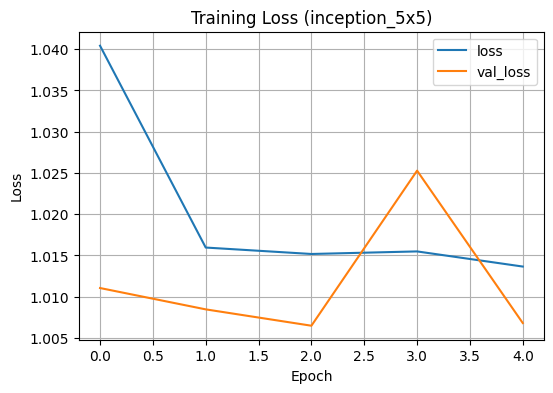

In [6]:
# Load best weights if saved
if os.path.exists("models/LAB3EX/inception_5x5.h5"):
    model.load_weights("models/LAB3EX/inception_5x5.h5")

# Build arrays of true labels and predicted labels on validation set
y_true = []
y_pred = []

# val_ready yields (inputs, labels)
for batch_inputs, batch_labels in val_ready:
    preds = model.predict(batch_inputs, verbose=0)
    pred_ids = np.argmax(preds, axis=1)
    y_pred.extend(pred_ids.tolist())
    y_true.extend(batch_labels.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc = accuracy_score(y_true, y_pred)
print(f"Validation accuracy: {acc:.4f}")

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows=true, cols=pred):")
print(cm)

# Print class mapping for clarity
print("Class index -> name mapping:")
for i, cname in train_ds_src.idx_to_class.items():
    print(i, cname)

# Plot loss + val_loss from history
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='val_loss')
plt.title(f"Training Loss ({APPROACH})")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Approach 2: Fusion 2D CNN (Early Fusion)

In [2]:
class VideoDatasetFusion:
    """Video Dataset loader for Fusion experiments (Early & Late)."""

    def __init__(self, root_dir, split="train", num_frames=16):
        self.split = split
        self.num_frames = num_frames

        # Load .npz
        npz_path = os.path.join(root_dir, f"{split}.npz")
        data = np.load(npz_path, allow_pickle=True)
        self.videos = list(data["X"])
        self.labels = np.array(data["y"])
        self.ids = list(data["ids"])

        # Class maps
        all_classes = sorted({vid.split("/")[0] for vid in self.ids})
        self.class_to_idx = {cls: i for i, cls in enumerate(all_classes)}
        self.idx_to_class = {i: cls for cls, i in self.class_to_idx.items()}

        print(f"✅ Loaded {split}.npz: {len(self.videos)} samples, {len(all_classes)} classes")

    def _uniform_sample(self, frames, num_samples):
        n = len(frames)
        if n >= num_samples:
            idxs = np.linspace(0, n - 1, num_samples).astype(int)
            return frames[idxs]
        else:
            pad_len = num_samples - n
            pad = np.zeros((pad_len, *frames.shape[1:]), dtype=frames.dtype)
            return np.concatenate([pad, frames], axis=0)

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx, fusion="late"):
        frames = self.videos[idx].astype(np.float32) / 255.0
        sampled = self._uniform_sample(frames, self.num_frames)
        label = int(self.labels[idx])
        class_name = self.idx_to_class[label]

        if fusion == "early":
            # Concatenate frames along channel axis: (T, H, W, 3) -> (H, W, 3*T)
            H, W, C = sampled.shape[1:]
            sampled = sampled.reshape(H, W, C * self.num_frames)

        return sampled, label, class_name


def make_fusion_tf_dataset(dataset: VideoDatasetFusion, batch_size=4, shuffle=True, fusion="late"):
    """
    Returns a tf.data.Dataset that yields (X, y) only for Keras.
    """
    def gen():
        for i in range(len(dataset)):
            # ✅ Explicitly call __getitem__ with fusion
            x, y, _ = dataset.__getitem__(i, fusion=fusion)
            yield x, y

    if fusion == "early":
        output_shapes = ((112, 112, 3 * dataset.num_frames), ())
    else:
        output_shapes = ((dataset.num_frames, 112, 112, 3), ())

    output_types = (tf.float32, tf.int32)

    ds = tf.data.Dataset.from_generator(gen, output_types=output_types, output_shapes=output_shapes)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataset))
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

In [3]:
root_dir = "data/SYSU-CEUS-FLL_npz/"

train_dataset = VideoDatasetFusion(root_dir, split="train", num_frames=16)
test_dataset  = VideoDatasetFusion(root_dir, split="test", num_frames=16)

batch_size = 8

train_ds_early = make_fusion_tf_dataset(train_dataset, batch_size=batch_size, shuffle=True, fusion="early")
test_ds_early  = make_fusion_tf_dataset(test_dataset, batch_size=batch_size, shuffle=False, fusion="early")

✅ Loaded train.npz: 286 samples, 3 classes
✅ Loaded test.npz: 72 samples, 3 classes


In [4]:
save_dir = "models/LAB3_B"
os.makedirs(save_dir, exist_ok=True)

num_frames = 16
input_height = 112
input_width = 112
batch_size = 16
num_classes = len(train_dataset.idx_to_class)
epochs = 5

# ---------------------------
# Build 2D CNN Backbone
# ---------------------------
def build_backbone(input_shape, num_classes, first_conv_channels=16):
    model = models.Sequential()
    model.add(layers.Conv2D(first_conv_channels, (3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(32, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))

    model.add(layers.Conv2D(64, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [5]:
# ---------------------------
# Early Fusion Model
# ---------------------------
early_input_shape = (112, 112, 3*16)
early_model = build_backbone(early_input_shape, num_classes=len(train_dataset.idx_to_class), first_conv_channels=16)

early_model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

early_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 16)      6928      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 56, 56, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 28, 28, 32)        0

In [7]:
# ---------------------------
# Train & Save Early Fusion
# ---------------------------
history_early = early_model.fit(
    train_ds_early,
    validation_data=test_ds_early,
    epochs=5
)
early_model.save(os.path.join(save_dir, "early_fusion_model.h5"))

Epoch 1/5
36/36 [==============================] - 18s 121ms/step - loss: 1.0907 - sparse_categorical_accuracy: 0.5000 - val_loss: 1.0304 - val_sparse_categorical_accuracy: 0.5139
Epoch 2/5
36/36 [==============================] - 17s 106ms/step - loss: 1.0132 - sparse_categorical_accuracy: 0.5210 - val_loss: 1.0170 - val_sparse_categorical_accuracy: 0.5139
Epoch 3/5
36/36 [==============================] - 17s 108ms/step - loss: 1.0120 - sparse_categorical_accuracy: 0.5210 - val_loss: 1.0286 - val_sparse_categorical_accuracy: 0.5139
Epoch 4/5
36/36 [==============================] - 17s 114ms/step - loss: 1.0210 - sparse_categorical_accuracy: 0.5210 - val_loss: 1.0042 - val_sparse_categorical_accuracy: 0.5139
Epoch 5/5
36/36 [==============================] - 17s 109ms/step - loss: 0.9943 - sparse_categorical_accuracy: 0.5210 - val_loss: 0.9994 - val_sparse_categorical_accuracy: 0.5139


In [8]:
# ---------------------------
# Evaluate
# ---------------------------
early_eval = early_model.evaluate(test_ds_early)

print(f"Early Fusion Test Loss: {early_eval[0]:.4f}, Accuracy: {early_eval[1]:.4f}")

9/9 [==============================] - 3s 359ms/step - loss: 0.9994 - sparse_categorical_accuracy: 0.5139
Early Fusion Test Loss: 0.9994, Accuracy: 0.5139
